<a href="https://colab.research.google.com/github/nityamshah/datascience/blob/main/unit6/NityShahU6proj.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import numpy as np
import pandas as pd
import arviz as az
import pymc as pm
import matplotlib.pyplot as plt

In [13]:
!pip install git+https://github.com/pydata/xarray.git
import xarray as xr
!pip install bambi
import bambi as bmb

  Cloning https://github.com/pydata/xarray.git to /tmp/pip-req-build-wptfie_7
  Running command git clone --filter=blob:none --quiet https://github.com/pydata/xarray.git /tmp/pip-req-build-wptfie_7
  Resolved https://github.com/pydata/xarray.git to commit d7ac79a3f869d91ea942a57c963b2e82e272fe93
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


# Greenhouse Gas Emissions by Population

This is a dataset that compares greenhouse gas emissions per 100k people and population in ten millions of ten different countries overtime. One thing that's interesting about this set of data is that without taking year into account the population data still hold information about time. This data spans from 1970 to 2012.

In [3]:
#load the data into a pandas dataframe
url_greenhouse = 'https://raw.githubusercontent.com/thedarredondo/data-science-fundamentals/main/Data/greenhousegas_pop_10nations.csv'
greenhouse = pd.read_csv(url_greenhouse, dtype={'country':'category'})

In [4]:
greenhouse

,country,code,year,grnGasEm100K,pop10M
0,Brazil,BRA,1970,12.6098,9.5982
1,Canada,CAN,1970,4.9497,2.1324
2,China,CHN,1970,18.7397,81.8315
3,Germany,DEU,1970,12.8657,7.8169
4,France,FRA,1970,6.1450,5.2035
...,...,...,...,...,...
425,United Kingdom,GBR,2012,5.8578,6.3700
426,India,IND,2012,30.0289,126.3590
427,Japan,JPN,2012,14.7886,12.7561
428,Mexico,MEX,2012,6.6342,12.2071


<Axes: xlabel='year', ylabel='grnGasEm100K'>

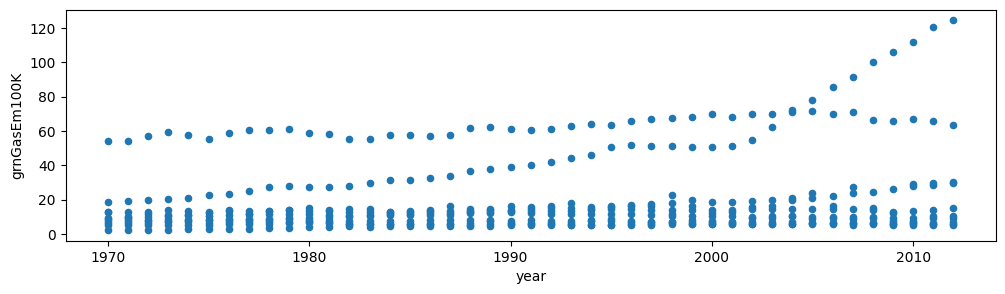

In [5]:
greenhouse.plot(x="year", y="grnGasEm100K", figsize=(12, 3), kind="scatter")

This is very chaotic data because each country has different GHG emission trends. So, I will eventually take country into account. For now, I'm starting simple just to see what happens.

Using Bambi to make a simple one variable/one predictor model: year vs. GHGemissions

Output()

Output()

/usr/local/lib/python3.11/dist-packages/arviz/rcparams.py:368: FutureWarning: stats.hdi_prob is deprecated since 0.18.0, use stats.ci_prob instead
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arviz/rcparams.py:368: FutureWarning: stats.hdi_prob is deprecated since 0.18.0, use stats.ci_prob instead
  warnings.warn(


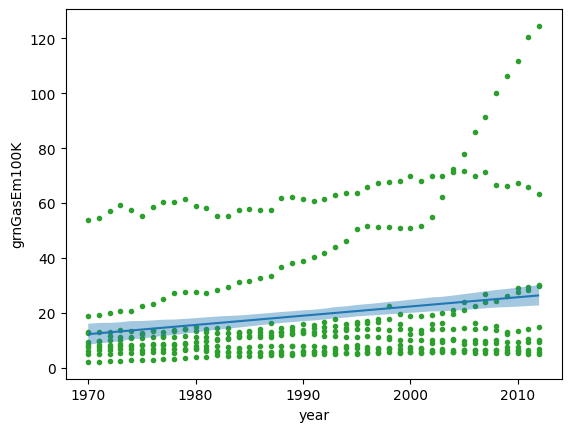

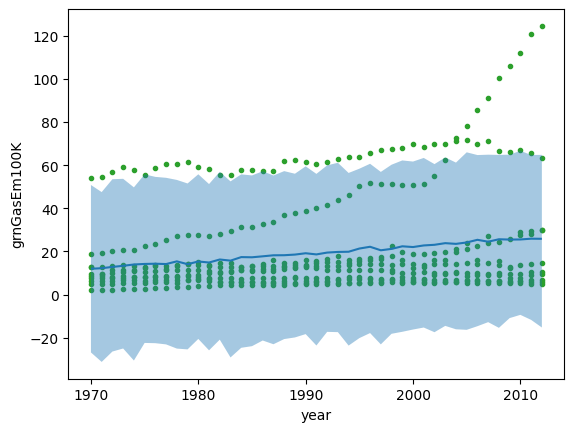

In [6]:
#define the model
model_1 = bmb.Model("grnGasEm100K ~ year", data=greenhouse)
#fit the model
idata_model_1 = model_1.fit(idata_kwargs={'log_likelihood': True})
#checking priors
model_1
#posterior mean and posterior predictive
bmb.interpret.plot_predictions(model_1, idata_model_1, "year")
plt.plot(greenhouse.year, greenhouse.grnGasEm100K, "C2.", zorder=-3)

bmb.interpret.plot_predictions(model_1, idata_model_1, "year", pps = True)
plt.plot(greenhouse.year, greenhouse.grnGasEm100K, "C2.", zorder=-3)

Clearly the model is confused because it's not aware of the different countries. I'm now going to introduce countries as a predictor.

Output()

Output()

/usr/local/lib/python3.11/dist-packages/arviz/rcparams.py:368: FutureWarning: stats.hdi_prob is deprecated since 0.18.0, use stats.ci_prob instead
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arviz/rcparams.py:368: FutureWarning: stats.hdi_prob is deprecated since 0.18.0, use stats.ci_prob instead
  warnings.warn(


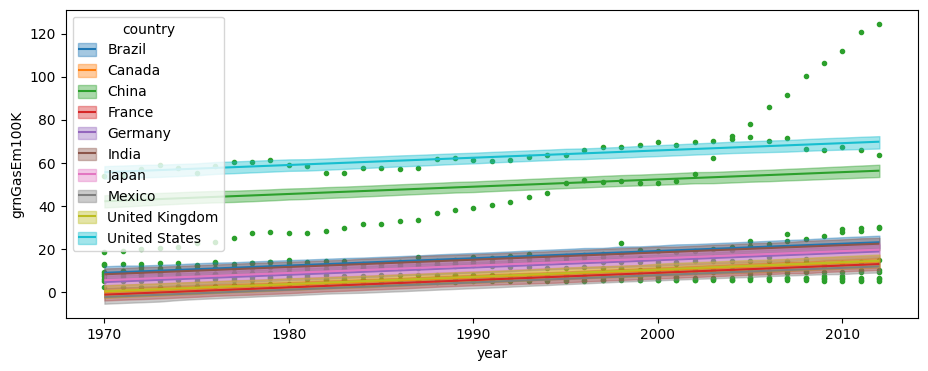

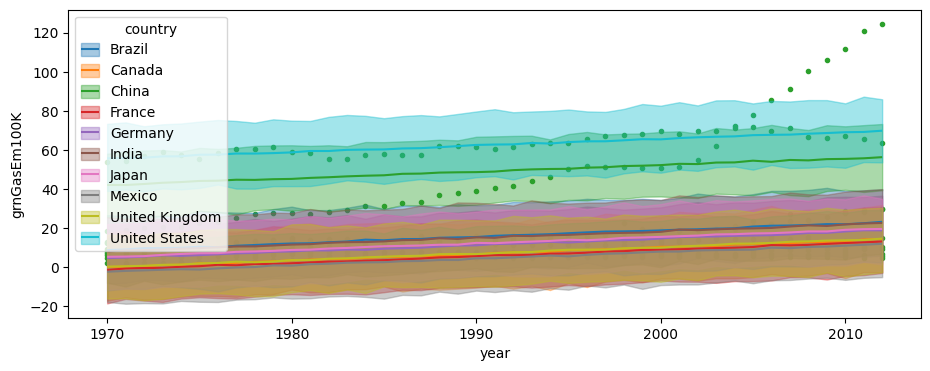

In [7]:
#define the model
model_country = bmb.Model("grnGasEm100K ~ year + country", data=greenhouse)
#fit the model
idata_model_country = model_country.fit(idata_kwargs={'log_likelihood': True})
#checking priors
model_country
#posterior mean and posterior predictive
bmb.interpret.plot_predictions(model_country, idata_model_country, ["year", "country"], fig_kwargs={"figsize":(11, 4)})
plt.plot(greenhouse.year, greenhouse.grnGasEm100K, "C2.", zorder=-3)

bmb.interpret.plot_predictions(model_country, idata_model_country, ["year", "country"], fig_kwargs={"figsize":(11, 4)}, pps = True)
plt.plot(greenhouse.year, greenhouse.grnGasEm100K, "C2.", zorder=-3)

It appears that all the countries have similar slopes. The model is not able to distinguish countries like India and China from the rest. I'm going to create an interaction between country and year. I want to try this even though it doesn't seem that intuitive because the emission trends over time will differ by countries as they develop at different paces.

Output()

Output()

/usr/local/lib/python3.11/dist-packages/arviz/rcparams.py:368: FutureWarning: stats.hdi_prob is deprecated since 0.18.0, use stats.ci_prob instead
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arviz/rcparams.py:368: FutureWarning: stats.hdi_prob is deprecated since 0.18.0, use stats.ci_prob instead
  warnings.warn(


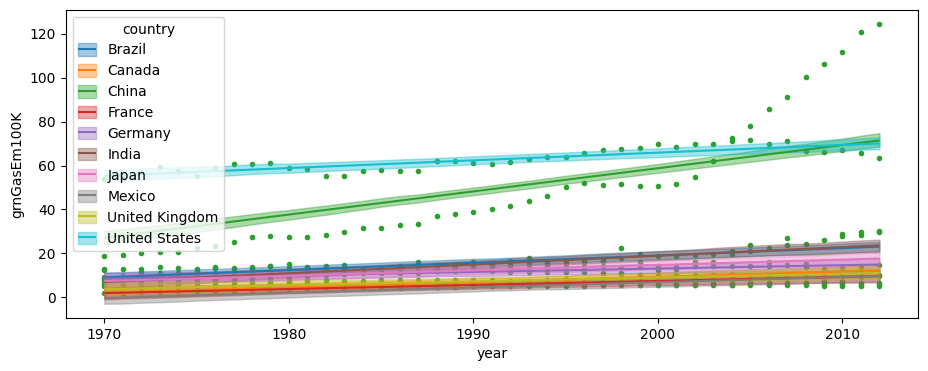

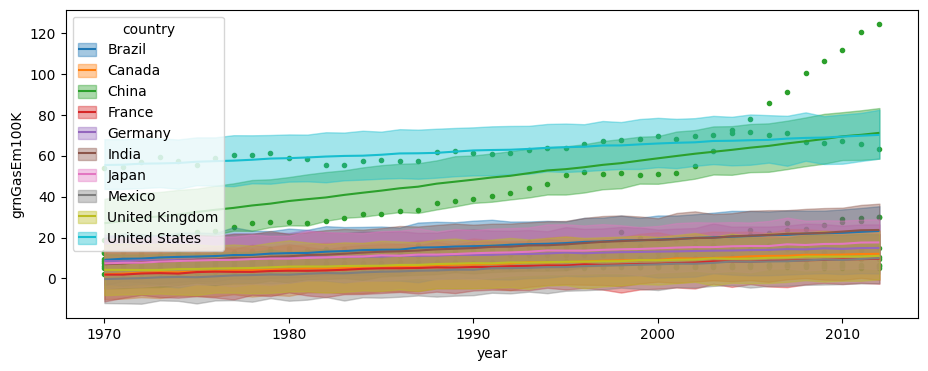

In [10]:
#define the model
model_countryint = bmb.Model("grnGasEm100K ~ year + country + year:country", data=greenhouse)
#fit the model
idata_model_countryint = model_countryint.fit(idata_kwargs={'log_likelihood': True})
#checking priors
model_countryint
#posterior mean and posterior predictive
bmb.interpret.plot_predictions(model_countryint, idata_model_countryint, ["year", "country"], fig_kwargs={"figsize":(11, 4)})
plt.plot(greenhouse.year, greenhouse.grnGasEm100K, "C2.", zorder=-3)

bmb.interpret.plot_predictions(model_countryint, idata_model_countryint, ["year", "country"], fig_kwargs={"figsize":(11, 4)}, pps = True)
plt.plot(greenhouse.year, greenhouse.grnGasEm100K, "C2.", zorder=-3)

This looks much better now that slopes are actually aligning with each country. This tells us that there is some kind of interaction between country and year even though intutively that's not so clear. I now want to add in the population variable because I believe that might have an impact on greenhouse gas emissions.

In [12]:
#define the model
model_popcountryint = bmb.Model("grnGasEm100K ~ year + country + pop10M + year:country", data=greenhouse)
#fit the model
idata_model_popcountryint = model_popcountryint.fit(idata_kwargs={'log_likelihood': True})

Output()

Output()

/usr/local/lib/python3.11/dist-packages/arviz/rcparams.py:368: FutureWarning: stats.hdi_prob is deprecated since 0.18.0, use stats.ci_prob instead
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arviz/rcparams.py:368: FutureWarning: stats.hdi_prob is deprecated since 0.18.0, use stats.ci_prob instead
  warnings.warn(


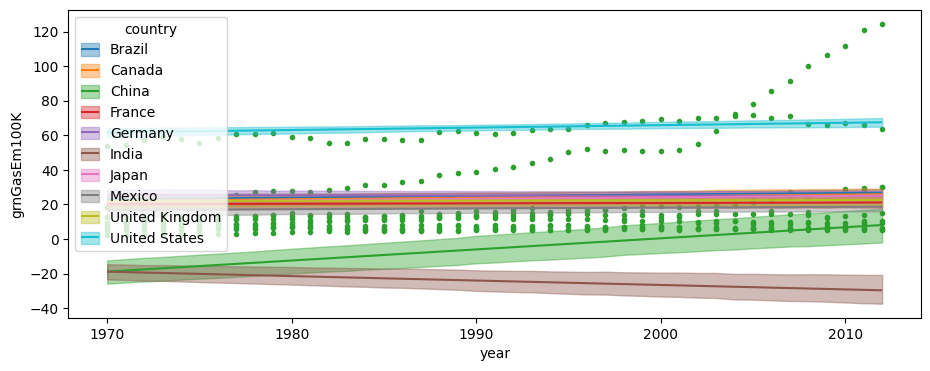

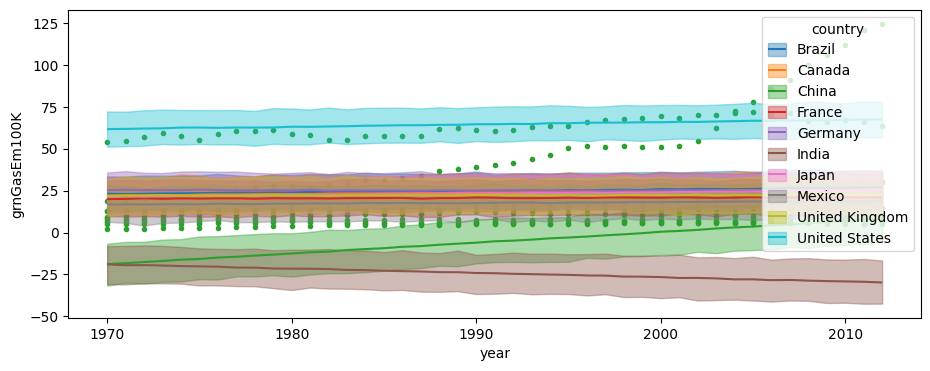

In [14]:
#posterior mean and posterior predictive
bmb.interpret.plot_predictions(model_popcountryint, idata_model_popcountryint, ["year", "country"], fig_kwargs={"figsize":(11, 4)})
plt.plot(greenhouse.year, greenhouse.grnGasEm100K, "C2.", zorder=-3)

bmb.interpret.plot_predictions(model_popcountryint, idata_model_popcountryint, ["year", "country"], fig_kwargs={"figsize":(11, 4)}, pps = True)
plt.plot(greenhouse.year, greenhouse.grnGasEm100K, "C2.", zorder=-3)

This one doesn't look as good as I expected. It has greenhouse gas emissions that go into the negatives and the slopes for countries like India and China are especially off.

I'm not sure why exactly emissions are going into the negatives, but I'm now going to compare these three models with elpd_loo to see which ones elpd_loo thinks are stronger.
1. Model with just year and country as predictors
2. Model with an interaction between year and country
3. Model with an interaction between year and country as well as population as a predictor

/usr/local/lib/python3.11/dist-packages/arviz/stats/stats.py:795: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.70 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arviz/stats/stats.py:795: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.70 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arviz/stats/stats.py:795: UserWarning: Estimat

<Axes: title={'center': 'Model comparison\nhigher is better'}, xlabel='elpd_loo (log)', ylabel='ranked models'>

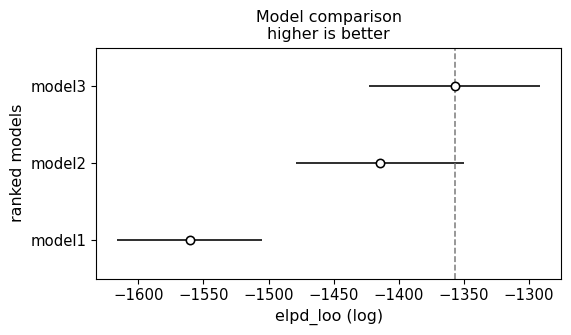

In [15]:
loo_1 = az.loo(idata_model_country)
loo_2 = az.loo(idata_model_countryint)
loo_3 = az.loo(idata_model_popcountryint)

cmp_df = az.compare( {"model1":idata_model_country, "model2":idata_model_countryint, "model3":idata_model_popcountryint} )
cmp_df
az.plot_compare(cmp_df)

From this comparison we can see that the second and third models appear to be better by elpd_loo. Model 2 and 3 overlap quite a bit conveying that one is not necessecarily much better than the other. But, because the second model looks right, makes sense, and doesn't have the same flaws as model 3, I'm choosing it to be a better model. The third model doesn't look right because it has negative values and slopes that seem inaccurate. It appears that there might some hidden variable besides these 3 predictors like GDP playing into this so, I want to look into that.


Because it feels as if there's a background variable playing into this model that correlates to the development of the countries over time like GDP, I'm going to pull data from the world bank on GDP and add that into this dataset.

In [16]:
#load the data into a pandas dataframe
urlgdp = 'https://raw.githubusercontent.com/nityamshah/datascience/main/data/API_NY.GDP.MKTP.CD_DS2_en_csv_v2_2.csv'
gdp = pd.read_csv(urlgdp, skiprows=4)
Countries = ['Brazil', 'Canada', 'China', 'Germany', 'France', 'United Kingdom', 'India', 'Japan', 'Mexico', 'United States']
filtered_gdp = gdp[gdp['Country Name'].isin(Countries)]
years = [str(year) for year in range(1970, 2013)]  # Generate list of years from 1970 to 2012
filtered_gdp = filtered_gdp[['Country Name'] + years]
filtered_gdp

,Country Name,1970,1971,1972,1973,1974,1975,1976,1977,1978,...,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012
29,Brazil,4.232766e+10,4.886983e+10,5.843486e+10,8.359228e+10,1.097945e+11,1.292036e+11,1.531689e+11,1.763441e+11,2.002786e+11,...,5.582337e+11,6.692894e+11,8.916338e+11,1.107627e+12,1.397114e+12,1.695855e+12,1.666996e+12,2.208838e+12,2.616156e+12,2.465228e+12
35,Canada,8.819226e+10,9.960645e+10,1.134638e+11,1.317643e+11,1.609492e+11,1.744198e+11,2.072716e+11,2.123252e+11,2.193695e+11,...,8.955406e+11,1.026690e+12,1.173109e+12,1.319265e+12,1.468820e+12,1.552990e+12,1.374625e+12,1.617343e+12,1.793327e+12,1.828366e+12
40,China,9.260263e+10,9.980059e+10,1.136893e+11,1.385432e+11,1.441890e+11,1.634295e+11,1.539393e+11,1.749359e+11,1.495408e+11,...,1.660281e+12,1.955347e+12,2.285961e+12,2.752119e+12,3.550328e+12,4.594337e+12,5.101691e+12,6.087192e+12,7.551546e+12,8.532185e+12
55,Germany,2.166292e+11,2.509009e+11,3.008999e+11,3.998336e+11,4.469350e+11,4.924341e+11,5.216587e+11,6.026983e+11,7.431829e+11,...,2.534716e+12,2.852318e+12,2.893393e+12,3.046309e+12,3.484057e+12,3.808786e+12,3.479801e+12,3.468154e+12,3.824829e+12,3.597897e+12
77,France,1.469270e+11,1.642389e+11,2.016218e+11,2.623438e+11,2.831022e+11,3.567807e+11,3.684883e+11,4.067365e+11,5.017244e+11,...,1.835096e+12,2.109792e+12,2.192146e+12,2.317862e+12,2.655817e+12,2.926803e+12,2.700076e+12,2.646230e+12,2.870409e+12,2.683007e+12
81,United Kingdom,1.306719e+11,1.481139e+11,1.699650e+11,1.925380e+11,2.061314e+11,2.417566e+11,2.326146e+11,2.630665e+11,3.358830e+11,...,2.054423e+12,2.421525e+12,2.543180e+12,2.708442e+12,3.090510e+12,2.929412e+12,2.412840e+12,2.485483e+12,2.663806e+12,2.707090e+12
109,India,6.242248e+10,6.735140e+10,7.146470e+10,8.551767e+10,9.952660e+10,9.847383e+10,1.027165e+11,1.214866e+11,1.373023e+11,...,6.077007e+11,7.091527e+11,8.203838e+11,9.402599e+11,1.216736e+12,1.198895e+12,1.341888e+12,1.675616e+12,1.823052e+12,1.827638e+12
119,Japan,2.172237e+11,2.453641e+11,3.249338e+11,4.414606e+11,4.900358e+11,5.328614e+11,5.988839e+11,7.370693e+11,1.035612e+12,...,4.519562e+12,4.893116e+12,4.831467e+12,4.601663e+12,4.579751e+12,5.106679e+12,5.289493e+12,5.759072e+12,6.233147e+12,6.272363e+12
154,Mexico,3.552000e+10,3.920000e+10,4.520000e+10,5.528000e+10,7.200000e+10,8.800000e+10,8.887592e+10,8.191202e+10,1.026486e+11,...,7.655500e+11,8.194592e+11,9.175719e+11,1.020265e+12,1.102356e+12,1.161553e+12,9.434374e+11,1.105424e+12,1.229014e+12,1.255110e+12
251,United States,1.073303e+12,1.164850e+12,1.279110e+12,1.425376e+12,1.545243e+12,1.684904e+12,1.873412e+12,2.081826e+12,2.351599e+12,...,1.145645e+13,1.221720e+13,1.303920e+13,1.381558e+13,1.447423e+13,1.476986e+13,1.447807e+13,1.504897e+13,1.559973e+13,1.625397e+13


I'm merging this dataset with my original one for ease.

In [17]:
#used chatgpt to help with this merging
gdp_reshaped = pd.melt(filtered_gdp, id_vars=['Country Name'], value_vars=years, var_name='Year', value_name='GDP')
gdp_reshaped['Year'] = gdp_reshaped['Year'].astype(int)
gdp_reshaped
merged_data = pd.merge(greenhouse, gdp_reshaped, how='left', left_on=['country', 'year'], right_on=['Country Name', 'Year'])
merged_data.drop(columns=['Year', 'Country Name'], inplace=True)
merged_data

,country,code,year,grnGasEm100K,pop10M,GDP
0,Brazil,BRA,1970,12.6098,9.5982,4.232766e+10
1,Canada,CAN,1970,4.9497,2.1324,8.819226e+10
2,China,CHN,1970,18.7397,81.8315,9.260263e+10
3,Germany,DEU,1970,12.8657,7.8169,2.166292e+11
4,France,FRA,1970,6.1450,5.2035,1.469270e+11
...,...,...,...,...,...,...
425,United Kingdom,GBR,2012,5.8578,6.3700,2.707090e+12
426,India,IND,2012,30.0289,126.3590,1.827638e+12
427,Japan,JPN,2012,14.7886,12.7561,6.272363e+12
428,Mexico,MEX,2012,6.6342,12.2071,1.255110e+12


I'm now going to make a model that takes this GDP into account. I'm going to add country, population and GDP as predictors and make an interaction between country+population and country+GDP.

In [18]:
#define the model
model_gdp = bmb.Model("grnGasEm100K ~ country + pop10M + GDP + country:pop10M + country+GDP", data=merged_data)
#fit the model
idata_model_gdp = model_gdp.fit(idata_kwargs={'log_likelihood': True})

Output()

Output()

ERROR:pymc.stats.convergence:The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


/usr/local/lib/python3.11/dist-packages/arviz/rcparams.py:368: FutureWarning: stats.hdi_prob is deprecated since 0.18.0, use stats.ci_prob instead
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arviz/rcparams.py:368: FutureWarning: stats.hdi_prob is deprecated since 0.18.0, use stats.ci_prob instead
  warnings.warn(


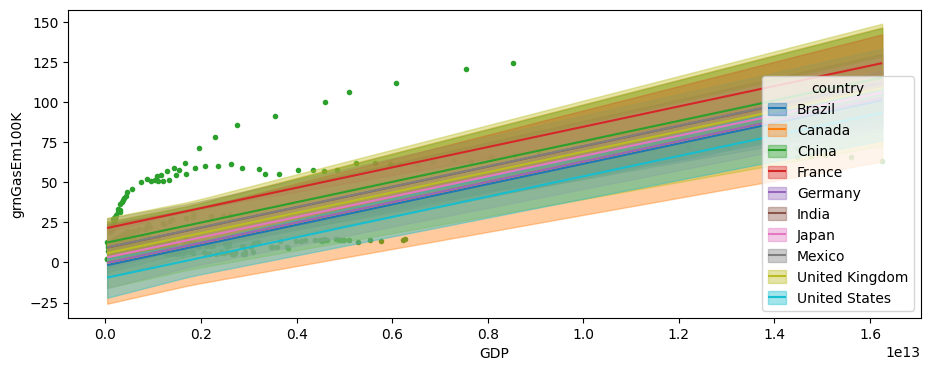

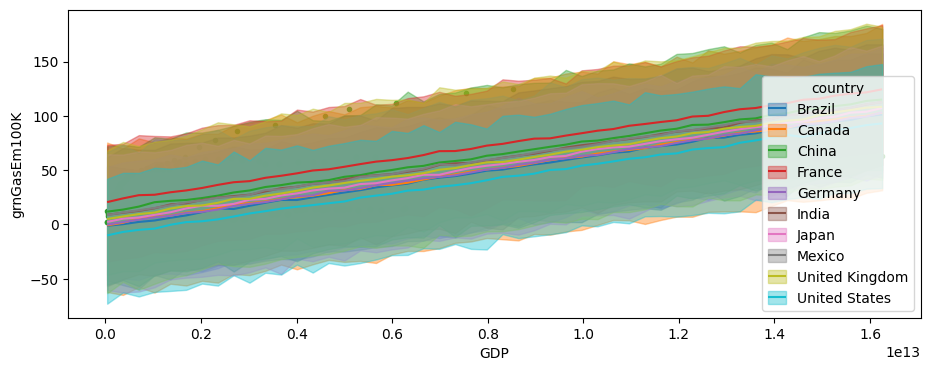

In [19]:
#posterior mean and posterior predictive
bmb.interpret.plot_predictions(model_gdp, idata_model_gdp, ["GDP", "country"], fig_kwargs={"figsize":(11, 4)})
plt.plot(merged_data.GDP, merged_data.grnGasEm100K, "C2.", zorder=-3)

bmb.interpret.plot_predictions(model_gdp, idata_model_gdp, ["GDP", "country"], fig_kwargs={"figsize":(11, 4)}, pps = True)
plt.plot(merged_data.GDP, merged_data.grnGasEm100K, "C2.", zorder=-3)

I'm now going to get the elpd_loo of this GDP model to compare it to the good models from before (Model with an interaction between year and country)

/usr/local/lib/python3.11/dist-packages/arviz/stats/stats.py:795: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.70 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arviz/stats/stats.py:795: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.70 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


<Axes: title={'center': 'Model comparison\nhigher is better'}, xlabel='elpd_loo (log)', ylabel='ranked models'>

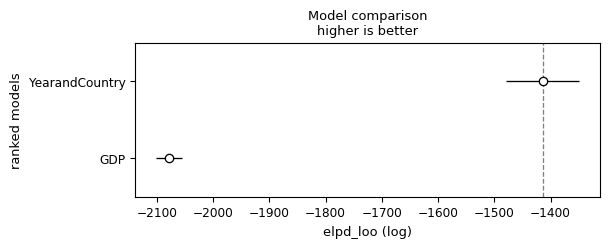

In [23]:
loo_gdp = az.loo(idata_model_gdp)
loo_yearandcountry = az.loo(idata_model_countryint)

cmp_df = az.compare( {"GDP":idata_model_gdp, "YearandCountry":idata_model_countryint} )
cmp_df
az.plot_compare(cmp_df)

The elpd_loo of this is around -2100 which is much worse than the previous models of around -1400. So, this one is actually doing worse. Thus, my best model is the one with just country, year and an interaction between the two.


These models are all using normal likelihoods. In my previous project, I established that StudentT worked well for this data, so I want to test that out. The family for StudentT is called "t". I'll compare this to the model with a normal likelihood to see which is better.


Below is the good model (country, year and an interaction between the two) with a Student T likelihood.

In [21]:
#define the model
model_countryintT = bmb.Model("grnGasEm100K ~ year + country + year:country", data=greenhouse, family = "t")
#fit the model
idata_model_countryintT = model_countryintT.fit(idata_kwargs={'log_likelihood': True})

Output()

Output()

ERROR:pymc.stats.convergence:The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


Below I'm comparing the Normal and Student T versions of the model with an interaction between year and country with elpd_loo.

/usr/local/lib/python3.11/dist-packages/arviz/stats/stats.py:795: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.70 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arviz/stats/stats.py:795: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.70 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


<Axes: title={'center': 'Model comparison\nhigher is better'}, xlabel='elpd_loo (log)', ylabel='ranked models'>

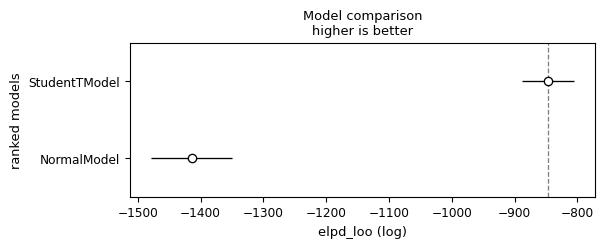

In [22]:
loo_norm = az.loo(idata_model_countryint)
loo_T = az.loo(idata_model_countryintT)

cmp_df = az.compare( {"NormalModel":idata_model_countryint, "StudentTModel":idata_model_countryintT} )
cmp_df
az.plot_compare(cmp_df)

This tells us that the student T model performs better than the normal model as expected. Thus my best model to predict greenhouse gas emissions of these ten countries is the Student T Model with country and year as predictors and an interaction between country and year.